## This code takes the college basketball data and models it. It goes through the process of optimizing each model and then creates a function that outputs predicted basketball scores for a set of two schools playing each other

In [32]:
#import packages
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [2]:
#create function for evaluating training models
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    r2 = model.score(test_features,test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('R^2 = {:0.2f}%.'.format(r2))
    
    return(accuracy)
    

In [3]:
#import data
full_data = pd.read_csv("College Data/All Teams Data.csv")

In [4]:
#inspect data columns
full_data.columns

Index(['G', 'Date', 'Opp', 'W/L', 'Tm', 'Opp.1', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1',
       'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1',
       'PF.1'],
      dtype='object')

In [5]:
full_data['eFG'] = (full_data["FG"] + (0.5 * full_data['3P'])) / full_data['FGA']
full_data['eFG.1'] = (full_data["FG.1"] + (0.5 * full_data['3P.1'])) / full_data['FGA.1']

full_data['TOV%'] = (full_data['TOV'] / (full_data['FGA'] + (0.44 * full_data['FTA']) + full_data['TOV'])) * 100
full_data['TOV%.1'] = (full_data['TOV.1'] / (full_data['FGA.1'] + (0.44 * full_data['FTA.1']) + full_data['TOV.1'])) * 100

full_data['ORB%'] = (full_data['ORB'])/((full_data['ORB']) + (full_data['TRB.1'] - full_data['ORB.1']))
full_data['ORB%.1'] = (full_data['ORB.1'])/((full_data['ORB.1']) + (full_data['TRB'] - full_data['ORB']))

full_data['FT/FGA'] = full_data['FT']/full_data['FGA']
full_data['FT/FGA.1'] = full_data['FT.1']/full_data['FGA.1']

full_data['DRB%'] = (full_data['TRB'] - full_data['ORB'])/((full_data['TRB'] - full_data['ORB']) + (full_data['ORB.1']))
full_data['DRB%.1'] = (full_data['TRB'] - full_data['ORB'])/((full_data['TRB'] - full_data['ORB']) + (full_data['ORB.1']))

full_data['AST%'] = full_data['AST'] / full_data['FG']
full_data['AST%.1'] = full_data['AST.1'] / full_data['FG.1']

full_data['TS%'] = 0.5 * (full_data['Tm'])/((full_data['FGA']) + 0.44 * (full_data['FTA']))
full_data['TS%.1'] = 0.5 * (full_data['Opp.1'])/((full_data['FGA.1']) + 0.44 * (full_data['FTA.1']))

full_data['3PAr'] = full_data['3PA'] / full_data['FGA']
full_data['3PAr.1'] = full_data['3PA.1'] / full_data['FGA.1']

full_data['DRB'] = full_data['TRB'] - full_data['ORB']
full_data['DRB.1'] = full_data['TRB.1'] - full_data['ORB.1']




full_data['POSS'] = (full_data['FGA'] - full_data['ORB']) + full_data['TOV'] + (0.44 * full_data['FTA'])
full_data['POSS.1'] = (full_data['FGA.1'] - full_data['ORB.1']) + full_data['TOV.1'] + (0.44 * full_data['FTA.1'])


full_data['3PAr'] = full_data['3PA'] / full_data['FGA']                           
full_data['3PAr.1'] = full_data['3PA.1'] / full_data['FGA.1']


full_data['OffRt'] = (full_data['Tm'] / full_data['POSS']) * 100
full_data['OffRt.1'] = (full_data['Opp.1'] / full_data['POSS.1']) * 100

full_data['DefRt'] = (full_data['Opp.1'] / full_data['POSS']) * 100
full_data['DefRt.1'] = (full_data['Tm'] / full_data['POSS.1']) * 100

In [6]:
full_data.head()

,G,Date,Opp,W/L,Tm,Opp.1,FG,FGA,FG%,3P,...,3PAr,3PAr.1,DRB,DRB.1,POSS,POSS.1,OffRt,OffRt.1,DefRt,DefRt.1
0,1,2022-11-07,Jackson State,W,65,56,23,57,0.404,8,...,0.491228,0.345455,28,33,76.80,75.16,84.635417,74.507717,72.916667,86.482171
1,2,2022-11-11,Texas A&M,L,58,77,20,52,0.385,8,...,0.346154,0.363636,15,23,68.28,68.40,84.944347,112.573099,112.770943,84.795322
2,3,2022-11-15,McMurry,W,104,46,41,68,0.603,5,...,0.250000,0.448980,29,13,80.68,78.60,128.904313,58.524173,57.015369,132.315522
3,4,2022-11-21,Wright State,L,61,77,25,58,0.431,7,...,0.379310,0.220000,20,23,79.40,75.36,76.826196,102.176221,96.977330,80.944798
4,5,2022-11-22,Weber State,L,67,77,26,53,0.491,9,...,0.320755,0.411765,20,21,70.84,72.00,94.579334,106.944444,108.695652,93.055556


In [7]:
#drop unneeded columns
fields_to_drop = ['G', 'Date', 'Opp', 'W/L', 'Tm', 'Opp.1',
                  'FG','FGA','3P','3PA','FT','FTA',
                  'FG.1','FGA.1','3P.1','3PA.1','FT.1','FTA.1']



In [8]:
#Create training and test data
X = full_data.drop(fields_to_drop, 1).dropna().drop_duplicates()
X = pd.get_dummies(X)
y = full_data[['Tm', 'Opp.1']].values
y = np.delete(y, 10081, axis = 0)
y = np.delete(y, 10244, axis = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = )

/var/folders/9y/pc8nlck558b1pf4sh_3_bh1h0000gn/T/ipykernel_1290/2481144508.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = full_data.drop(fields_to_drop, 1).dropna().drop_duplicates()


In [9]:
#run a linear regression model on training data
reg = linear_model.LinearRegression()

In [10]:
reg.fit(X_train,y_train)

LinearRegression()

In [11]:
#evalute the model
evaluate(reg, X_train,y_train)

Model Performance
Average Error: 0.5563 degrees.
Accuracy = 99.18%.
R^2 = 1.00%.


99.17528991629443

In [12]:
#create and fit a random forest regression model on training data
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Feature: 0, Score: 0.00051
Feature: 1, Score: 0.00043
Feature: 2, Score: 0.00039
Feature: 3, Score: 0.00027
Feature: 4, Score: 0.00034
Feature: 5, Score: 0.00051
Feature: 6, Score: 0.00030
Feature: 7, Score: 0.00030
Feature: 8, Score: 0.00029
Feature: 9, Score: 0.00035
Feature: 10, Score: 0.00058
Feature: 11, Score: 0.00042
Feature: 12, Score: 0.00041
Feature: 13, Score: 0.00023
Feature: 14, Score: 0.00035
Feature: 15, Score: 0.00038
Feature: 16, Score: 0.00026
Feature: 17, Score: 0.00025
Feature: 18, Score: 0.00028
Feature: 19, Score: 0.00031
Feature: 20, Score: 0.00042
Feature: 21, Score: 0.00050
Feature: 22, Score: 0.00039
Feature: 23, Score: 0.00038
Feature: 24, Score: 0.00035
Feature: 25, Score: 0.00026
Feature: 26, Score: 0.00039
Feature: 27, Score: 0.00043
Feature: 28, Score: 0.00029
Feature: 29, Score: 0.00027
Feature: 30, Score: 0.00038
Feature: 31, Score: 0.00038
Feature: 32, Score: 0.00060
Feature: 33, Score: 0.00075
Feature: 34, Score: 0.00042
Feature: 35, Score: 0.00042
Fe

<BarContainer object of 44 artists>

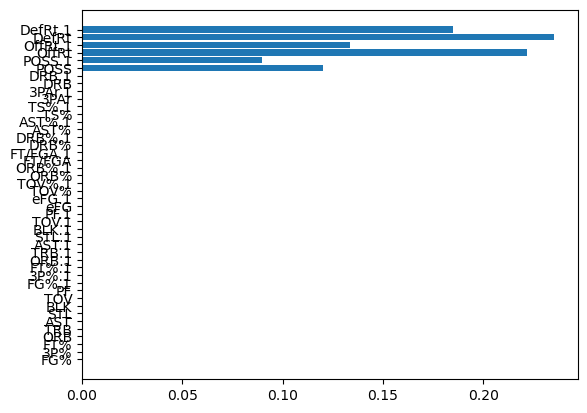

In [33]:
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh(X.columns, rf.feature_importances_)

In [29]:
X.columns

Index(['FG%', '3P%', 'FT%', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'FG%.1', '3P%.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1',
       'TOV.1', 'PF.1', 'eFG', 'eFG.1', 'TOV%', 'TOV%.1', 'ORB%', 'ORB%.1',
       'FT/FGA', 'FT/FGA.1', 'DRB%', 'DRB%.1', 'AST%', 'AST%.1', 'TS%',
       'TS%.1', '3PAr', '3PAr.1', 'DRB', 'DRB.1', 'POSS', 'POSS.1', 'OffRt',
       'OffRt.1', 'DefRt', 'DefRt.1'],
      dtype='object')

In [13]:
#investigate random forest regressor function base arguments/hyperparamters
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [14]:
#create a grid of randomly sampled values for hyperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100,
                                            stop = 1000,
                                            num = 10)]
# Number of features to consider at every split
max_features = ['log2','sqrt',1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10,
                                         110,
                                         num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['log2', 'sqrt', 1.0],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [15]:
#create a model for each of the randomly selected sets of model hyperparameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 5, verbose=3,
                               random_state=42, n_jobs = -1)

In [16]:
#fit each of the models and use cross validation to determine best fitting model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=900;, score=0.953 total time=  32.1s
[CV 4/5] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.986 total time=  28.7s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.953 total time=   6.5s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.951 total time=   6.4s
[CV 3/5] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=0.941 total time=  12.0s
[CV 1/5] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=0.952 total time=  21.5s


/Users/piercecappelli/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=900;, score=0.956 total time=  32.1s
[CV 5/5] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.985 total time=  28.9s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.948 total time=   6.6s
[CV 1/5] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=0.945 total time=  11.6s
[CV 4/5] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=0.942 total time=  12.4s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=0.953 total time=  21.5s
[CV 2/5] END bootstrap=False, max_depth=20, max_features=log2, min_samples_

[CV 5/5] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=0.986 total time= 1.6min
[CV 1/5] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.988 total time=  12.2s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.989 total time=  12.3s
[CV 1/5] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.962 total time=   3.3s
[CV 4/5] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.959 total time=   3.3s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=0.962 total time= 1.6min
[CV 5/5] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=1

[CV 4/5] END bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=900;, score=0.950 total time=  27.8s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.952 total time=  11.1s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.948 total time=  11.8s
[CV 2/5] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=700;, score=0.991 total time= 1.6min
[CV 3/5] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=700;, score=0.940 total time=  12.3s
[CV 5/5] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=0.959 total time=  13.3s
[CV 3/5] END bootstrap=False, max_depth=None, max_features=1.0, min_sampl

[CV 4/5] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=900;, score=0.963 total time= 3.1min
[CV 2/5] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=0.967 total time=  27.3s
[CV 5/5] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=0.963 total time=  26.1s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700;, score=0.944 total time=  13.4s
[CV 1/5] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.959 total time=  18.8s
[CV 2/5] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.961 total time=  19.2s
[CV 3/5] END bootstrap=False, max_depth=40, max_features=log2, min_sampl

[CV 4/5] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.963 total time= 1.7min
[CV 4/5] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.952 total time=   4.2s
[CV 4/5] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=0.951 total time=  16.6s
[CV 5/5] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.958 total time= 1.7min
[CV 3/5] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=0.956 total time= 2.1min
[CV 5/5] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.958 total time= 1.7min
[CV 3/5] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf

[CV 1/5] END bootstrap=True, max_depth=100, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.990 total time=  13.5s
[CV 2/5] END bootstrap=True, max_depth=100, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.991 total time=  13.4s
[CV 5/5] END bootstrap=True, max_depth=100, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.987 total time=  13.5s
[CV 3/5] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.959 total time=  22.4s
[CV 1/5] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=0.964 total time=  17.2s
[CV 2/5] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=0.964 total time=  17.0s
[CV 5/5] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_lea

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt', 1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=3)

In [17]:
#obtain hyperparameters from best fitting model
best_random_params = rf_random.best_params_
best_random_params

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 1.0,
 'max_depth': 110,
 'bootstrap': True}

In [18]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_train, y_train)

Model Performance
Average Error: 0.2281 degrees.
Accuracy = 99.67%.
R^2 = 1.00%.


In [19]:
#compare model performance from default hyperparameter random forest and
 #best fitting randomly selected hyperparamter random forest
base_accuracy = evaluate(rf, X_train, y_train)
random_accuracy = evaluate(best_random, X_train, y_train)

Model Performance
Average Error: 0.2555 degrees.
Accuracy = 99.63%.
R^2 = 1.00%.
Model Performance
Average Error: 0.2281 degrees.
Accuracy = 99.67%.
R^2 = 1.00%.


In [20]:
#determine amount of improvement from base random forest
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.04%.


In [48]:
#Create a narrowed down version hyperparameter values using the random search as a base for the values
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [17,18,19],
    'max_features': [0.9,1.0],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [598,599,600]
}

# create models from every combination of hyperparameter listed above
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 3)

In [49]:
#fit models
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [15, 16, 17, 18, 19, 10],
                         'max_features': [0.9, 1.0], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [598, 599, 600]},
             verbose=3)

In [50]:
#investigate best fitting model hyperparamters
best_grid_params = grid_search.best_params_
best_grid_params

{'bootstrap': True,
 'max_depth': 18,
 'max_features': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 599}

In [51]:
#investigate new model fit
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_train, y_train)

Model Performance
Average Error: 0.2236 degrees.
Accuracy = 99.67%.
R^2 = 1.00%.


In [53]:
#display improvement from best random search hyper parameter values to specific hyper parameter values models
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - random_accuracy) / random_accuracy))

Improvement of 0.01%.


In [54]:
#display improvement from base hyper parameter values to specific hyper parameter values models
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.05%.
[CV 1/5] END bootstrap=True, max_depth=15, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=599;, score=0.990 total time= 1.3min
[CV 3/5] END bootstrap=True, max_depth=15, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.986 total time= 1.3min
[CV 2/5] END bootstrap=True, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=599;, score=0.991 total time= 1.4min
[CV 5/5] END bootstrap=True, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.987 total time= 1.4min
[CV 4/5] END bootstrap=True, max_depth=16, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=599;, score=0.988 total time= 1.3min
[CV 2/5] END bootstrap=True, max_depth=16, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=598;, score=0.991 total time= 1.4min
[CV 5/5] END bootstrap=True, max_depth=16, max_features=1.0, min_s

[CV 1/5] END bootstrap=True, max_depth=15, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=598;, score=0.990 total time= 1.3min
[CV 5/5] END bootstrap=True, max_depth=15, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=599;, score=0.987 total time= 1.3min
[CV 3/5] END bootstrap=True, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=598;, score=0.986 total time= 1.4min
[CV 1/5] END bootstrap=True, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.990 total time= 1.4min
[CV 5/5] END bootstrap=True, max_depth=16, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=598;, score=0.987 total time= 1.3min
[CV 3/5] END bootstrap=True, max_depth=16, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.986 total time= 1.3min
[CV 1/5] END bootstrap=True, max_depth=16, max_features=1.0, min_samples_leaf=1, min_sam

[CV 2/5] END bootstrap=True, max_depth=15, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=599;, score=0.991 total time= 1.3min
[CV 2/5] END bootstrap=True, max_depth=15, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.991 total time= 1.3min
[CV 4/5] END bootstrap=True, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=598;, score=0.988 total time= 1.4min
[CV 2/5] END bootstrap=True, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.991 total time= 1.4min
[CV 1/5] END bootstrap=True, max_depth=16, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=599;, score=0.990 total time= 1.3min
[CV 4/5] END bootstrap=True, max_depth=16, max_features=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.988 total time= 1.3min
[CV 2/5] END bootstrap=True, max_depth=16, max_features=1.0, min_samples_leaf=1, min_sam

In [55]:
#fit training data using optimized random forest hyper parameter values
best_rf = RandomForestRegressor(n_estimators = 599,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                               max_features = 1.0,
                                max_depth = 18,
                                bootstrap = True)

In [56]:
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=18, n_estimators=599)

In [57]:
#evaluate fit
evaluate(best_rf, X_train, y_train)

Model Performance
Average Error: 0.2223 degrees.
Accuracy = 99.68%.
R^2 = 1.00%.


99.67545144384903

In [58]:
#fit a base Gradient Boosted model to training data
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state = 42))


In [59]:
gbr.fit(X_train,y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42))

In [60]:
#investigate its performance
base_gbr_accuracy = evaluate(gbr, X_train, y_train)
evaluate(gbr, X_train, y_train)

Model Performance
Average Error: 0.4331 degrees.
Accuracy = 99.38%.
R^2 = 1.00%.
Model Performance
Average Error: 0.4331 degrees.
Accuracy = 99.38%.
R^2 = 1.00%.


99.38150870949605

In [374]:
#investigate gradient boosted default hyper parameter values
print('Parameters currently in use:\n')
pprint(gbr.get_params())

Parameters currently in use:

{'estimator': GradientBoostingRegressor(random_state=42),
 'estimator__alpha': 0.9,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'squared_error',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 42,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'n_jobs': None}


In [393]:
#optimize the number of estimators first
param_test1 = {'estimator__n_estimators':range(455,466,1)}
gsearch1 = GridSearchCV(estimator = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.1,
                                                                                   min_samples_split=500,
                                                                                   min_samples_leaf=50,
                                                                                   max_depth=8,
                                                                                   max_features='sqrt',
                                                                                   random_state=42)), 
param_grid = param_test1,n_jobs=-1, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=8,
                                                                                max_features='sqrt',
                                                                                min_samples_leaf=50,
                                                                                min_samples_split=500,
                                                                                random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__n_estimators': range(455, 466)})

In [394]:
#display number of estimators resulting in best fit
gsearch1_best = gsearch1.best_params_
gsearch1_best

{'estimator__n_estimators': 461}

In [416]:
#optimize 'max depth', 'min_samples_split', and 'min_samples_leaf' next while inserting best 'n_estimators' value
param_test2 = {'estimator__max_depth':range(5,7,1),
               'estimator__min_samples_split':range(790,811,1),
              'estimator__min_samples_leaf': range(15,18,1)}
gsearch2 = GridSearchCV(estimator = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.1,
                                                                                   n_estimators=461,
                                                                                   max_features='sqrt',
                                                                                   random_state=42)), 
param_grid = param_test2,n_jobs=-1, cv=5, verbose = 3)
gsearch2.fit(X_train,y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(max_features='sqrt',
                                                                                n_estimators=461,
                                                                                random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': range(5, 7),
                         'estimator__min_samples_leaf': range(15, 18),
                         'estimator__min_samples_split': range(790, 811)},
             verbose=3)

In [417]:
#obtain best fitting values
gsearch2_best = gsearch2.best_params_
gsearch2_best

{'estimator__max_depth': 6,
 'estimator__min_samples_leaf': 15,
 'estimator__min_samples_split': 800}

In [420]:
#optimize 'max_features' while inserting best fitting 'max_depth',' min_samples_leaf', and 'min_samples_split' values
param_test3 = {'estimator__max_features':range(1,21,1)}
gsearch3 = GridSearchCV(estimator = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.1,
                                                                                   n_estimators=461,
                                                                                   max_depth = 6,
                                                                                   min_samples_split = 800,
                                                                                   min_samples_leaf=15,
                                                                                   random_state=42)), 
param_grid = param_test3,n_jobs=-1, cv=5, verbose = 3)
gsearch3.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=6,
                                                                                min_samples_leaf=15,
                                                                                min_samples_split=800,
                                                                                n_estimators=461,
                                                                                random_state=42)),
             n_jobs=-1, param_grid={'estimator__max_features': range(1, 21)},
             verbose=3)

In [532]:
#obtain values from best fitting model
gsearch3_best = gsearch3.best_params_
gsearch3_best

{'estimator__max_features': 15}

In [426]:
#optimize 'subsample' while inserting 'max_features' value
param_test4 = {'estimator__subsample':[0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.89,0.90]}
gsearch4 = GridSearchCV(estimator = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.1,
                                                                                   n_estimators=461,
                                                                                   max_depth = 6,
                                                                                   min_samples_split = 800,
                                                                                   min_samples_leaf=15,
                                                                                   max_features = 15,
                                                                                   random_state=42)), 
param_grid = param_test4,n_jobs=-1, cv=5, verbose = 3)
gsearch4.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=6,
                                                                                max_features=15,
                                                                                min_samples_leaf=15,
                                                                                min_samples_split=800,
                                                                                n_estimators=461,
                                                                                random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__subsample': [0.81, 0.82, 0.83, 0.84, 0.85,
                                                  0.86, 0.87, 0.89, 0.9]},
             verbose=3)

In [427]:
#obtain value for best fitting model
gsearch4_best = gsearch4.best_params_
gsearch4_best

{'estimator__subsample': 0.85}

In [437]:
#optimize 'learning_rate' and reoptimize 'n_estimators' as they are highly related while inserting
 #all other optimized values
param_test5 = {'estimator__learning_rate':[0.07,0.06,0.05],
              'estimator__n_estimators':range(860,871,1)}
gsearch5 = GridSearchCV(estimator = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=461,
                                                                                   max_depth = 6,
                                                                                   min_samples_split = 800,
                                                                                   min_samples_leaf=15,
                                                                                   max_features = 15,
                                                                                   subsample = 0.85,
                                                                                   random_state=42)), 
param_grid = param_test5,n_jobs=-1, cv=5, verbose = 3)
gsearch5.fit(X_train,y_train)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=6,
                                                                                max_features=15,
                                                                                min_samples_leaf=15,
                                                                                min_samples_split=800,
                                                                                n_estimators=461,
                                                                                random_state=42,
                                                                                subsample=0.85)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.07, 0.06, 0.05],
                         'estimator__n_estimators': range(860, 871)},
             verbose=3)

In [533]:
#obtain values from best fitting model
gsearch5_best = gsearch5.best_params_
gsearch5_best

{'estimator__learning_rate': 0.06, 'estimator__n_estimators': 869}

In [73]:
#creating Gradient Boosted model with all optimized parameters inserted
gbr_opt = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=869,
                                               learning_rate = 0.06,
                                               max_depth = 6,
                                               min_samples_split = 800,
                                               min_samples_leaf=15,
                                               max_features = 15,
                                               subsample = 0.85,
                                               random_state=42))

In [74]:
#fitting model to the training data
gbr_opt.fit(X_train,y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.06,
                                                         max_depth=6,
                                                         max_features=15,
                                                         min_samples_leaf=15,
                                                         min_samples_split=800,
                                                         n_estimators=869,
                                                         random_state=42,
                                                         subsample=0.85))

In [75]:
opt_gbr_accuracy = evaluate(gbr_opt, X_train, y_train)
opt_gbr_accuracy

Model Performance
Average Error: 2.1966 degrees.
Accuracy = 96.85%.
R^2 = 0.95%.


96.84579507919167

In [538]:
#display improvement from best random search hyper parameter values to specific hyper parameter values models
print('Improvement of {:0.2f}%.'.format( 100 * (opt_gbr_accuracy - base_gbr_accuracy) / base_gbr_accuracy))

Improvement of 1.50%.


In [ ]:
#Review all three final models performance

In [461]:
#Regression
evaluate(reg, X_train,y_train)

Model Performance
Average Error: 3.1916 degrees.
Accuracy = 95.40%.
R^2 = 0.92%.


95.39591191919399

In [462]:
#Random Forest
evaluate(best_rf, X_train, y_train)

Model Performance
Average Error: 1.7704 degrees.
Accuracy = 97.42%.
R^2 = 0.97%.


97.41639573185135

In [489]:
#Gradient Boosting
evaluate(gbr_opt, X_train, y_train)

Model Performance
Average Error: 2.0834 degrees.
Accuracy = 97.00%.
R^2 = 0.96%.


96.99549632247225

In [ ]:
#predict test data outcomes for each model and calculate MSE for each

In [34]:
#Regression
reg_pred = reg.predict(X_test)
reg_MSE = np.mean((reg_pred - y_test) ** 2)
print("MSE: %r " % reg_MSE)

MSE: 0.70637445747579 


In [35]:
#Random Forest
rf_pred = rf.predict(X_test)
rf_MSE = np.mean((rf_pred - y_test) ** 2)
print("MSE: %r " % rf_MSE)

MSE: 1.6073913192071085 


In [91]:
#Gradient Boosting
gbr_pred = gbr_opt.predict(X_test)
gbr_MSE = np.mean((gbr_pred - y_test) ** 2)
print("MSE: %r " % gbr_MSE)

MSE: 15.011084400855989 


In [92]:
#Combine prediction values by taking weighted mean
# with weights being the inverse of the model MSE

In [93]:
#create weighted predicitons
weighted_pred = ((reg_pred*(1/reg_MSE)) + (rf_pred*(1/rf_MSE)) + (gbr_pred*(1/gbr_MSE))) / ((1/reg_MSE) + (1/rf_MSE) + (1/gbr_MSE))
weighted_pred = weighted_pred.round(0)

In [94]:
#calculate MSE for weighted predicitions
weighted_MSE = np.mean((weighted_pred - y_test) ** 2)
print("MSE: %r " % weighted_MSE)

MSE: 15.642686261107313 


In [158]:
#Create a function that looks up two user specified schools then calculates their predicted scores if they
 #played each other

def predict_scores(first_team = "wisconsin", second_team = 'texas-christian'):
    
    teams1 = [first_team]
    #pull data from school url pages
    for name in teams1:


        with open("College Data/Schools/{}.html".format(name)) as f:
            page2 = f.read()

        soup = BeautifulSoup(page2, "html.parser")
        soup.find('tr', class_="over_header").decompose()
        stats_table = soup.find(id="div_sgl-basic_NCAAM")
        data = pd.read_html(str(stats_table))[0]

        data.drop(data[(data['FG%'] == "School") | (data['FG%'] == "FG%")].index, inplace=True)
        data['Unnamed: 2'] = data['Unnamed: 2'].replace("@","A").fillna("H")
        data = data.drop(columns = ["Unnamed: 23"]).dropna()
        data = data.drop(columns = ["W/L","G","Date","Unnamed: 2", "Opp"])
        

        data = data.astype(float)

        data['eFG'] = (data['FG'] + (0.5 * data['3P'])) / data['FGA']
        data['eFG.1'] = (data["FG.1"] + (0.5 * data['3P.1'])) / data['FGA.1']

        data['TOV%'] = (data['TOV'] / (data['FGA'] + (0.44 * data['FTA']) + data['TOV'])) * 100
        data['TOV%.1'] = (data['TOV.1'] / (data['FGA.1'] + (0.44 * data['FTA.1']) + data['TOV.1'])) * 100

        data['ORB%'] = (data['ORB'])/((data['ORB']) + (data['TRB.1'] - data['ORB.1']))
        data['ORB%.1'] = (data['ORB.1'])/((data['ORB.1']) + (data['TRB'] - data['ORB']))

        data['FT/FGA'] = data['FT']/data['FGA']
        data['FT/FGA.1'] = data['FT.1']/data['FGA.1']

        data['DRB%'] = (data['TRB'] - data['ORB'])/((data['TRB'] - data['ORB']) + (data['ORB.1']))
        data['DRB%.1'] = (data['TRB'] - data['ORB'])/((data['TRB'] - data['ORB']) + (data['ORB.1']))

        data['AST%'] = data['AST'] / data['FG']
        data['AST%.1'] = data['AST.1'] / data['FG.1']

        data['TS%'] = 0.5 * (data['Tm'])/((data['FGA']) + 0.44 * (data['FTA']))
        data['TS%.1'] = 0.5 * (data['Opp.1'])/((data['FGA.1']) + 0.44 * (data['FTA.1']))

        data['3PAr'] = data['3PA'] / data['FGA']
        data['3PAr.1'] = data['3PA.1'] / data['FGA.1']

        data['DRB'] = data['TRB'] - data['ORB']
        data['DRB.1'] = data['TRB.1'] - data['ORB.1']


        data['POSS'] = (data['FGA'] - data['ORB']) + data['TOV'] + (0.44 * data['FTA'])
        data['POSS.1'] = (data['FGA.1'] - data['ORB.1']) + data['TOV.1'] + (0.44 * data['FTA.1'])


        data['3PAr'] = data['3PA'] / data['FGA']                           
        data['3PAr.1'] = data['3PA.1'] / data['FGA.1']


        data['OffRt'] = (data['Tm'] / data['POSS']) * 100
        data['OffRt.1'] = (data['Opp.1'] / data['POSS.1']) * 100

        data['DefRt'] = (data['Opp.1'] / data['POSS']) * 100
        data['DefRt.1'] = (data['Tm'] / data['POSS.1']) * 100
        
        data = data[data.columns.drop(list(data.filter(regex='.1')))]       

    #Creates a data frame with the means for each variable across all the games
     #that school has played so far this season
        team1 = pd.DataFrame(data)
        team1 = team1.astype(float)\
        .mul((np.arange(1, len(team1)+1, 1))/(len(team1)), axis = 0)\
        .sum()\
        .div(sum((np.arange(1, len(team1)+1, 1))/(len(team1))))\
        .to_frame()\
        .T
        
        team1 = team1.drop(columns = ["Tm", "FG", "FGA", "3P", "3PA", "FT", "FTA"])
        
    teams2 = [second_team]

    for name in teams2:


        with open("College data/Schools/{}.html".format(name)) as f:
            page2 = f.read()

        soup = BeautifulSoup(page2, "html.parser")
        soup.find('tr', class_="over_header").decompose()
        stats_table = soup.find(id="div_sgl-basic_NCAAM")
        data2 = pd.read_html(str(stats_table))[0]

        data2.drop(data2[(data2['FG%'] == "School") | (data2['FG%'] == "FG%")].index, inplace=True)
        data2['Unnamed: 2'] = data2['Unnamed: 2'].replace("@","A").fillna("H")
#        data2 = data2[data2.columns.drop(list(data2.filter(regex='.1')))]
        data2 = data2.drop(columns = ["Unnamed: 23"]).dropna()
        data2 = data2.drop(columns = ["W/L","G","Date","Unnamed: 2", "Opp"])
        

        data2 = data2.astype(float)

        data2['eFG'] = (data2['FG'] + (0.5 * data2['3P'])) / data2['FGA']
        data2['eFG.1'] = (data2["FG.1"] + (0.5 * data2['3P.1'])) / data2['FGA.1']

        data2['TOV%'] = (data2['TOV'] / (data2['FGA'] + (0.44 * data2['FTA']) + data2['TOV'])) * 100
        data2['TOV%.1'] = (data2['TOV.1'] / (data2['FGA.1'] + (0.44 * data2['FTA.1']) + data2['TOV.1'])) * 100

        data2['ORB%'] = (data2['ORB'])/((data2['ORB']) + (data2['TRB.1'] - data2['ORB.1']))
        data2['ORB%.1'] = (data2['ORB.1'])/((data2['ORB.1']) + (data2['TRB'] - data2['ORB']))

        data2['FT/FGA'] = data2['FT']/data2['FGA']
        data2['FT/FGA.1'] = data2['FT.1']/data2['FGA.1']

        data2['DRB%'] = (data2['TRB'] - data2['ORB'])/((data2['TRB'] - data2['ORB']) + (data2['ORB.1']))
        data2['DRB%.1'] = (data2['TRB'] - data2['ORB'])/((data2['TRB'] - data2['ORB']) + (data2['ORB.1']))

        data2['AST%'] = data2['AST'] / data2['FG']
        data2['AST%.1'] = data2['AST.1'] / data2['FG.1']

        data2['TS%'] = 0.5 * (data2['Tm'])/((data2['FGA']) + 0.44 * (data2['FTA']))
        data2['TS%.1'] = 0.5 * (data2['Opp.1'])/((data2['FGA.1']) + 0.44 * (data2['FTA.1']))

        data2['3PAr'] = data2['3PA'] / data2['FGA']
        data2['3PAr.1'] = data2['3PA.1'] / data2['FGA.1']

        data2['DRB'] = data2['TRB'] - data2['ORB']
        data2['DRB.1'] = data2['TRB.1'] - data2['ORB.1']


        data2['POSS'] = (data2['FGA'] - data2['ORB']) + data2['TOV'] + (0.44 * data2['FTA'])
        data2['POSS.1'] = (data2['FGA.1'] - data2['ORB.1']) + data2['TOV.1'] + (0.44 * data2['FTA.1'])


        data2['3PAr'] = data2['3PA'] / data2['FGA']                           
        data2['3PAr.1'] = data2['3PA.1'] / data2['FGA.1']


        data2['OffRt'] = (data2['Tm'] / data2['POSS']) * 100
        data2['OffRt.1'] = (data2['Opp.1'] / data2['POSS.1']) * 100

        data2['DefRt'] = (data2['Opp.1'] / data2['POSS']) * 100
        data2['DefRt.1'] = (data2['Tm'] / data2['POSS.1']) * 100
        
        data2 = data2[data2.columns.drop(list(data2.filter(regex='.1')))]       

    #Creates a data2 frame with the means for each variable across all the games
     #that school has played so far this season
        team2 = pd.DataFrame(data2)
        team2 = team2.astype(float)\
        .mul((np.arange(1, len(team2)+1, 1))/(len(team2)), axis = 0)\
        .sum()\
        .div(sum((np.arange(1, len(team2)+1, 1))/(len(team2))))\
        .to_frame()\
        .T
        
        team2 = team2.drop(columns = ["Tm", "FG", "FGA", "3P", "3PA", "FT", "FTA"])
        
        team2.columns = team2.columns + ".1"
        
    #combine school data into a single row
    X_team_data = pd.concat([team1,team2], axis = 1)
    
    X_team_data = X_team_data[X_train.columns.tolist()]
    
    
    #predict scores for each school using all three models
    reg_pred = reg.predict(X_team_data)
    rf_pred = best_rf.predict(X_team_data)
    gbr_pred = gbr.predict(X_team_data)
    
    #create MSE scores
    reg_MSE = np.mean((reg_pred - y_test) ** 2)
    rf_MSE = np.mean((rf_pred - y_test) ** 2)
    gbr_MSE = np.mean((gbr_pred - y_test) ** 2)
    
    #weight and combine results for all three models
    weighted_pred = ((reg_pred*(1/reg_MSE)) + (rf_pred*(1/rf_MSE)) + (gbr_pred*(1/gbr_MSE))) / ((1/reg_MSE) + (1/rf_MSE) + (1/gbr_MSE))
    weighted_pred = weighted_pred.round(0).astype(int)
    
    #create data frame with column labels for output
    result = pd.DataFrame(weighted_pred, columns = [first_team,second_team])
    #output results
    return(result)
    

In [183]:
predict_scores("kansas", "howard")

,kansas,howard
0,72,72
